# Bioinfo Avancée TP 2 : évolution des séquences génétique

##Partie 1 : Evolution des séquences d'ADN

Nous allons simuler des chaînes de Markov pour faire évoluer des séquences d'ADN. Ces chaînes ont 4 états, un pour chaque nucléotide et forment un graphe complet, ou chaque état peut transitionner vers chaque autre et vers lui-même. On représente une telle chaîne sous la forme d'une matrice de taux de transitions $Q$ de taille 4$\times$4 où $q_{ij}$ donne le taux de mutation de $i \rightarrow j$ et
$$q_{ii}=-\sum\limits_{j} q_{ij}$$
de sorte que la somme de chaque ligne soit $0$

On simule une telle chaîne en deux étapes :
	1. En considérant que l'état actuel est $i$, le temps de résidence dans l'état $\tau$ correspond au temps avant qu'une transition sortante ne se produise, ce qui est fonction de $-q_{ii}$. Plus précisément, pour une chaîne de Markov en temps continue, ce temps est une valeur aléatoire distribuée selon une loi exponentielle :

$$τ \sim exp(-q_{ii} )$$.

  2. Une fois qu'on a déterminé le temps de sortie, il faut choisir l'état d'arrivé. La probabilité de sauter vers un autre état $j \neq i$ est donnée par :

$$p_{ij}=\frac{q_{ij}}{-q_{ii}}.$$

Appelons $u,v,w$ les trois états sortants de $i$ et formons le vecteur de leurs probabilitées cumulées

$$S=[p_{iu},p_{iu}+p_{iv},p_{iu}+p_{iv}+p_{iw}].$$

On va alors tirer une valeur aléatoire distribuée uniformément dans $[0,1]$ : $u \sim U([0,1])$ et chercher l'indice $k^*$ de l'élément minimum dans $S$ tel que $u \leq s_{k^*}$. Si $k^*$=0 alors l'état suivant est $u$, si $k^*=1$ c'est $v$ et si $k^*$=2 c'est $w$.
On va répéter ces deux opérations tant que $t<t_{max}$ avec à chaque itération $t=t+\tau$.



###Question 1

Simulez la chaîne pour $t_{max} = 50$ ans, un caractère initial "A" et la matrice $Q$ suivant le modèle JC69 avec $\mu = 0.1$ mutations par an.

In [53]:
nucleotides = [
    "A",
    "G",
    "C",
    "T",
]

(array([114., 183., 196., 342.,  87.,  42.,  29.,   3.,   2.,   2.]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <BarContainer object of 10 artists>)

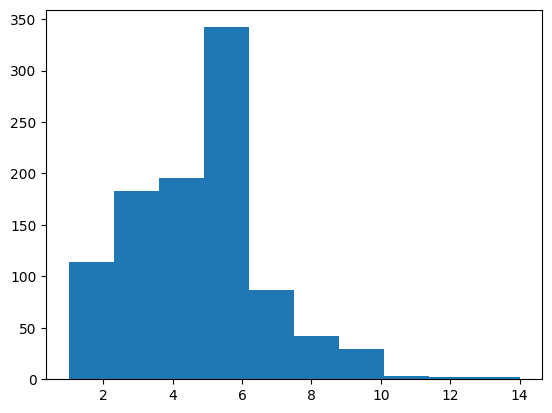

In [54]:
import numpy as np
def generation(tmax, s0, Q):
  t = 0
  rV = [s0]
  while t < tmax:
    np.random.seed()
    i = nucleotides.index(s0)
    tau = np.random.exponential(1 / -Q[i][i])
    t += tau
    if t >= tmax:
      t = tmax
      break

    k = np.random.uniform(0,1)
    S = [Q[i][j] / (-Q[i][i]) if i != j else 0 for j in range(4)]
    S = np.cumsum(S)
    for j in range(len(S)):
      if S[j] != 0 and k <= S[j]:
        s0 = nucleotides[j]
        break
    rV.append(s0)
  return rV

mu = 0.1
Q = [[mu/4 if i != j else -3 * mu / 4 for j in range(4)] for i in range(4)]
temp = []
for i in range(1000):
  temp.append(len("".join(generation(50, "A", Q))))

import matplotlib.pyplot as plt
plt.hist(temp)

###Question 2

Utilisez les même paramètres mais cette fois simulez l'évolution de la séquence s0 = "ATTGCGTAGCTAC"

In [78]:
temp = []
seq = "ATTGCGTAGCTAC"
res = ""
for s0 in seq:
  res += generation(50, s0, Q2)[-1]
res

'ATTTCCCGATAGA'

###Question 3

Même chose que la question 2 mais cette fois avec la matrice $Q$ suivant le modèle HYK85 avec la fréquence d'apparition de chaque caractère $\pi_n$ calculée sur s0 et $\kappa = 5$.

In [85]:
def HYK85_matrix(seq, k, mu):
  freq = {i: seq.count(i)/len(seq) for i in nucleotides}
  Q = [[(freq[key] * (k if j == (1 - i) % len(nucleotides) else 1) * mu if i != j else 0) for j,key in enumerate(freq.keys())] for i in range(len(nucleotides))]
  for i in range(len(Q)):
    Q[i][i] = -sum(Q[i])
  return Q


res = ""
Q2 = HYK85_matrix(seq, 5, mu)
for s0 in seq:
  res += generation(50, s0, Q2)[-1]
print(res)

ACCATGAGGTCCT


###Question 4

Faites varier $\kappa$ et regardez l'effet sur les séquences générées.

In [90]:
gens = []
for k in range(1, 100, 1):
  Q3 = HYK85_matrix(seq, k, mu)
  for s0 in nucleotides:
    gens.append(generation(50, s0, Q3))


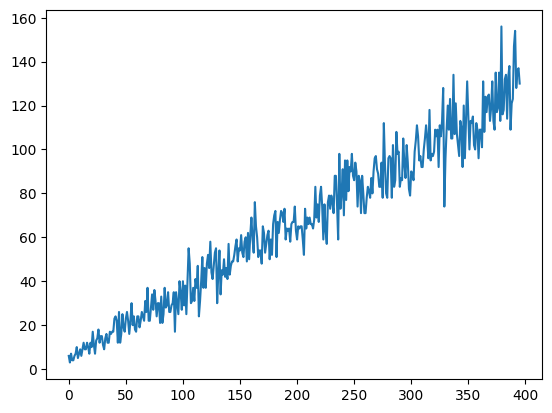

In [91]:
import matplotlib.pyplot as plt
plt.plot([len(gen) for gen in gens])

##Partie 2 : résolution de SUDOKU par algorithme évolutionnaire

Dans le cours, nous avons vu que la pression de sélection sur une population faisait augmenter l'adaptation moyenne de celle-ci au cours du temps. On peut utiliser le même principe pour résoudre des problèmes d'optimisation. Cette fois notre population consiste en un ensemble de solutions possibles au problème : c'est la famille des algorithmes génétiques.

###Algorithmes génétiques
Le principe d'un algorithme génétique est assez simple mais autorise beaucoup de variations :

----

1 Générer une population initiale d'individus

2 Tant que le critère d'arrêt n'est pas rempli :

3$\ \ \ \ $Sélectionner un sous-groupe d'individus qui vont se reproduire basé sur leur adaptation.

4$\ \ \ \ $Faire se reproduire aléatoirement les individus, en choisissant deux parents et générant une solution basée sur les leurs.

5$\ \ \ \ $Faire muter certains individus

6$\ \ \ \ $Evaluer les individus, chercher si on a pas une solution satisfaisante parmi eux et calculer l'adaptation moyenne de la population.

----

Cet algorithme va converger vers maximum local car à chaque itération on biaise la population vers les meilleurs individus. Comme tout algorithme d'optimisation, il y a un compromis entre découverte de nouvelles solutions et vitesse de convergence vers un maximum local. Ainsi on trouve plusieurs méta-paramètres dans ces algorithmes :

* Le taux de sélection des individus (étape 2.a), ici on veut choisir les meilleures solutions mais aussi d'autres solutions au hasard pour assurer la diversité de la population.
* Le taux de crossing-over pour les individus qui se reproduisent.
* Le taux de mutation pour chaque individu.
* La taille de la population. C'est le paramètre le plus important, en général, plus la population est grande, mieux c'est.

La formulation de l'algorithme est très simple, la complexité réside dans l'encodage du problème sous forme de gènes et la définition des opérateurs de reproduction et mutation. En particulier, il faut être capable de générer des solutions meilleures à partir de solutions existantes. Générer des solutions valides peut parfois être compliqué, on trouve alors deux écoles : générer des solutions aléatoires jusqu'à en obtenir une valide ou alors créer une procédure, plus complexe, pour générer des solutions valides. La méthode à utiliser dépendra du problème et de la complexité de vérifier une solution par rapport à la générer.

####Sudoku
Vous devriez tous êtres familiers avec le sudoku mais rappelons rapidement ses règles. On dispose d'une grille de taille 9x9, dans chaque case on doit entrer un chiffre entre 1 et 9. Pour résoudre la grille, il faut qu'il n'y ait aucune répétition de chiffre sur aucune ligne et colonne. La grille est aussi divisée en 9 carrés de taille 3x3 dans lesquels il ne doit pas y avoir de répétition mais c'est redondant avec les lignes et colonnes (s'il n'y a aucune répétition en ligne et colonne il n'y aura aucune répétition dans les carrés et vice versa). La grille initiale possède déjà certaines cases préremplies qui définissent la difficulté de la grille.

Le sudoku est intéressant car on peut facilement évaluer la qualité d'une solution, il suffit de s'assurer que toutes les valeurs sur les lignes et colonnes sont uniques.

#### Implémentation
Je vous propose une implémentation mais je vous encourage fortement à tester des versions alternatives en particulier s'il vous reste du temps avant la fin du TP.

En entrée notre solveur prend la grille initiale préremplie $G$ et les paramètres suivants :

* Nombre de générations N_gen (entier > 0).
* Taille de la population N (entier > 0).
* Taux de sélection des individus t_sel (entre 0 et 1).
* Taux de sélection aléatoire des individus t_sel_rnd (entre 0 et 1).
* Nombre d'enfant par couples : N_kids (entier > 0).
* Taux de mutation des enfants : mu (entre 0 et 1).


####Encodage du problème
On va considérer que chaque individu possède 9 chromosomes contenant chacun 9 valeurs entre 1 et 9, chaque chromosome représentant une ligne de la grille.

####Population initiale
Chaque individu de notre population de départ doit respecter les trois critères suivants :

* Être aléatoire ;
* Ne pas avoir de chiffre répété sur une même ligne (chromosome) ;
* Respecter les positions des valeurs de la grille de départ $G$.

Etant donné ces contraintes, générez $N$ individus.


####Score d'adaptation d'un individu

Le score d'adaptation d'un individu est donné par la somme pour chaque colonne du nombre de chiffres différents qu'elle contient (c'est-à-dire pour une même position sur chacun des chromosomes). La valeur maximale est de $81$.

####Sélection de la population
A cette étape, on choisit quels individus survivent et seront autorisés à se reproduire. Cette sélection se fait en deux étapes :

1. La fraction t_sel des individus les mieux adaptés survit forcément.
2. Choisir aléatoirement une fraction t_sel_rnd d'individus parmi la population restante.

La première étape permet de biaiser la population vers les individus les plus adaptés, alors que la deuxième permet d'assurer la diversité des individus. A la fin de cette étape, on a une fraction t_sel + t_sel_rnd de la population d'individus qui a survécu jusqu'à l'âge adulte et va se reproduire.


####Reproduction
On va former aléatoirement des paires d'individus parmi les adultes et les faire se reproduire pour générer N_kids enfants chacun. Notez que vous devez respecter la relation

(t_sel+t_sel_rnd)/2 * N_kids=1,

pour que la taille de la population reste constante.

Pour créer une nouvelle solution à partir des génomes des parents, on va tirer aléatoirement une position $0 \neq k < 9$ et prendre les chromosomes 0 à k d'un parent et k+1 à 8 de l'autre. On s'assure ainsi que nos solutions n'aient pas de chiffre répété par ligne et respectent la grille initiale.

####Mutation
Chaque enfant généré va muter avec une probabilité mu. Quand cela se produit, la stratégie la plus simple pour conserver l'unicité des valeurs par ligne, est d'échanger aléatoirement deux valeurs d'un même chromosome qui ne sont pas des positions de la grille initiale.

####Structure du code
Maintenant que l'on a vu les étapes individuelles vous devez les assembler pour former l'algorithme génétique. Voici l'idée :

----
1 Générez une population aléatoire de N individus

2 Tant que nombre de générations < max et qu'on a pas trouvé de solution optimale

3$\ \ \ \ $Sélectionnez la population d'individu mature
  
4$\ \ \ \ $Faites-les se reproduire
  
5$\ \ \ \ $Faites muter les enfants

----

Lorsque vous implémentez l'algorithme, vous pouvez affichez l'adaptation moyenne de la population à chaque génération, celui-ci devrait augmenter à chaque génération jusqu'à trouver la solution ou atteindre un plateau (être bloqué dans un maximum local).

Vous trouverez ici un ensemble de grilles initiales préremplies de sudoku.

A vous de jouer 😉

In [ ]:
print("Votre code ici !")

### Pour aller plus loin
Essayez de changer l'encodage (ex : 1 chromosome de 81 valeurs ?) et observez si le taux de convergence s'améliore.
